In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import accuracy

In [3]:
path = Path('data/hackerearth/dataset')

In [4]:
path.ls()

[PosixPath('data/hackerearth/dataset/Train Images'),
 PosixPath('data/hackerearth/dataset/test.csv'),
 PosixPath('data/hackerearth/dataset/export.pkl'),
 PosixPath('data/hackerearth/dataset/Test Images'),
 PosixPath('data/hackerearth/dataset/train.csv'),
 PosixPath('data/hackerearth/dataset/models')]

In [5]:
df = pd.read_csv(path/'train.csv')
df.head()

,Image,Class
0,image7042.jpg,Food
1,image3327.jpg,misc
2,image10335.jpg,Attire
3,image8019.jpg,Food
4,image2128.jpg,Attire


In [6]:
tfms = get_transforms()

In [7]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train.csv', folder='Train Images')
      .split_by_rand_pct(0.2)
      .label_from_df())

In [8]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

In [46]:
?(get_transforms())

Object `(get_transforms())` not found.


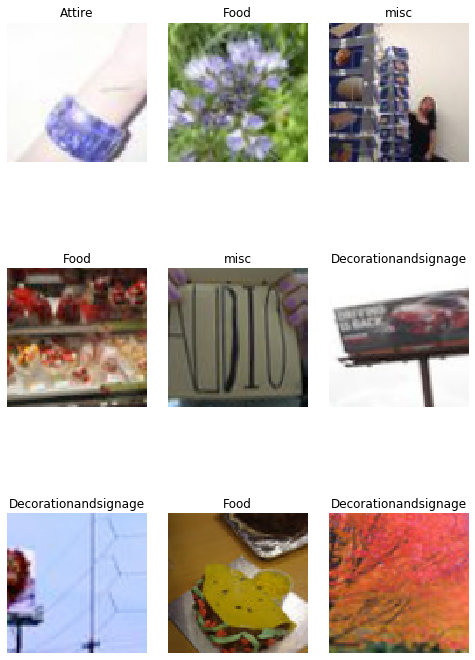

In [14]:
data.show_batch(rows=3, figsize=(7,11))

In [9]:
arch = models.resnet18

In [1]:
from sklearn.metrics import f1_score

In [18]:
def f1_loss(y_true:torch.Tensor, y_pred:torch.Tensor, is_training=False) -> torch.Tensor:
    '''Calculate F1 score. Can work with gpu tensors
    
    The original implmentation is written by Michal Haltuf on Kaggle.
    
    Returns
    -------
    torch.Tensor
        `ndim` == 1. 0 <= val <= 1
    
    Reference
    ---------
    - https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
    - https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265/6
    
    '''
    assert y_true.ndim == 1
    assert y_pred.ndim == 1 or y_pred.ndim == 2
    
    if y_pred.ndim == 2:
        y_pred = y_pred.argmax(dim=1)
        
    
    tp = (y_true * y_pred).sum().to(torch.float32)
    tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
    fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
    fn = (y_true * (1 - y_pred)).sum().to(torch.float32)
    
    epsilon = 1e-7
    
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1 = 2* (precision*recall) / (precision + recall + epsilon)
    f1.requires_grad = is_training
    return f1



In [10]:
learn = cnn_learner(data, arch, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


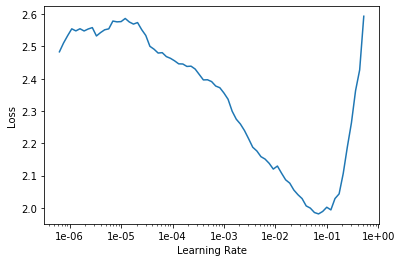

In [18]:
learn.lr_find()
learn.recorder.plot()

In [26]:
lr=1e-3

In [28]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.925106,1.200653,0.546823,00:04
1,1.468598,0.980450,0.663043,00:04
2,1.230893,0.979404,0.653846,00:04
3,1.058374,0.854285,0.686455,00:04
4,0.962272,0.820405,0.686455,00:04
5,0.873247,0.784657,0.711538,00:04
6,0.840319,0.758419,0.711538,00:04
7,0.793872,0.744114,0.714047,00:04
8,0.784716,0.744049,0.717391,00:04
9,0.756748,0.741018,0.717391,00:04


In [59]:
learn.save('stage-1')

In [60]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


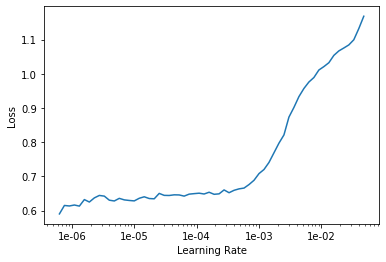

In [61]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr=

In [62]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, lr/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.659250,0.615340,0.772575,00:07
1,0.658289,0.591508,0.785953,00:07
2,0.584834,0.589502,0.789298,00:07
3,0.525467,0.570044,0.798495,00:07
4,0.499004,0.567052,0.797659,00:07


In [63]:
learn.save('stage-2')

In [11]:
learn.export()

In [12]:
test = ImageList.from_folder(path/'Test Images')
len(test)

3219

In [13]:
learn = load_learner(path, test=test)
preds, ids = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
pd

In [20]:
learn.data.classes[:]

['Attire', 'Decorationandsignage', 'Food', 'misc']

In [21]:
len(preds)

3219

In [18]:
preds[:10]

tensor([[5.5717e-03, 9.3346e-03, 9.2623e-07, 9.8509e-01],
        [8.7412e-04, 8.5500e-03, 8.1139e-07, 9.9058e-01],
        [6.5267e-03, 2.0025e-02, 8.4451e-06, 9.7344e-01],
        [3.0770e-02, 2.6340e-02, 7.9596e-07, 9.4289e-01],
        [7.4260e-03, 1.8732e-01, 2.3102e-05, 8.0523e-01],
        [8.8541e-02, 4.8824e-02, 2.9025e-03, 8.5973e-01],
        [1.3511e-01, 3.9437e-02, 2.6910e-08, 8.2545e-01],
        [1.3005e-02, 9.8522e-01, 1.4285e-04, 1.6337e-03],
        [2.9846e-03, 8.9924e-02, 1.8000e-07, 9.0709e-01],
        [2.4056e-04, 6.0700e-05, 7.7686e-09, 9.9970e-01]])

In [14]:
df = pd.DataFrame(preds, columns=learn.data.classes)

In [15]:
df.index+=1

In [16]:
df = df.assign(Label = df.values.argmax(axis=1))

In [17]:
df[:10]

,Attire,Decorationandsignage,Food,misc,Label
1,tensor(0.0056),tensor(0.0093),tensor(9.2623e-07),tensor(0.9851),3
2,tensor(0.0009),tensor(0.0085),tensor(8.1139e-07),tensor(0.9906),3
3,tensor(0.0065),tensor(0.0200),tensor(8.4451e-06),tensor(0.9734),3
4,tensor(0.0308),tensor(0.0263),tensor(7.9596e-07),tensor(0.9429),3
5,tensor(0.0074),tensor(0.1873),tensor(2.3102e-05),tensor(0.8052),3
6,tensor(0.0885),tensor(0.0488),tensor(0.0029),tensor(0.8597),3
7,tensor(0.1351),tensor(0.0394),tensor(2.6910e-08),tensor(0.8255),3
8,tensor(0.0130),tensor(0.9852),tensor(0.0001),tensor(0.0016),1
9,tensor(0.0030),tensor(0.0899),tensor(1.8000e-07),tensor(0.9071),3
10,tensor(0.0002),tensor(6.0700e-05),tensor(7.7686e-09),tensor(0.9997),3


In [33]:
df = df.assign(image =  fnames)

In [28]:
df = df.replace({'Label':{0:'Attire', 1:'Decorationandsignage', 2:'Food', 3:'misc'}})

In [30]:
df = df.drop(['Attire','Decorationandsignage','Food','misc'], axis=1)

In [46]:
df[:10]

,Image,Class
1,image3739.jpg,misc
2,image10654.jpg,misc
3,image6985.jpg,misc
4,image9561.jpg,misc
5,image8994.jpg,misc
6,image9647.jpg,misc
7,image5733.jpg,misc
8,image5227.jpg,Decorationandsignage
9,image4597.jpg,misc
10,image5371.jpg,misc


In [38]:
df = df[['image', 'Label']]

In [45]:
df = df.rename({'image': 'Image'}, axis=1)

In [57]:
thresh = 0.2725646197795868
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [58]:
labelled_preds[:5]

['Food', 'Attire Food', 'misc', 'misc', 'Attire']

In [20]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [21]:
fnames[:5]

['image3739', 'image10654', 'image6985', 'image9561', 'image8994']

In [22]:
suffix='.jpg'

In [23]:
fnames= [sub+suffix for sub in fnames]

In [22]:
learn.data.test_ds.items[:5]

array([PosixPath('data/hackerearth/dataset/Test Images/image3739.jpg'),
       PosixPath('data/hackerearth/dataset/Test Images/image10654.jpg'),
       PosixPath('data/hackerearth/dataset/Test Images/image6985.jpg'),
       PosixPath('data/hackerearth/dataset/Test Images/image9561.jpg'),
       PosixPath('data/hackerearth/dataset/Test Images/image8994.jpg')], dtype=object)

In [36]:
df = pd.DataFrame({'Image':fnames, 'Class':labelled_preds})

In [48]:
df.head()

,Image,Class
1,image3739.jpg,misc
2,image10654.jpg,misc
3,image6985.jpg,misc
4,image9561.jpg,misc
5,image8994.jpg,misc


In [47]:
df.to_csv('submission.csv')